[View in Colaboratory](https://colab.research.google.com/github/jeffgreenca/White-Sturgeon-Colony-Analysis/blob/master/Colony_Analysis.ipynb)

# Analysis of Colony output

This notebook takes Colony simulation results as input, generated using simulated data, and performs a series of data analysis steps to evaluate performance of the Colony application.  The simulation data contains unique identifiers allowing the "correct" answers to be reconstructed by examining the individual member's name:

* `AxB-#` where `A` is one parent, `B` is the other parent, and `#` is the ID of this individual.

# Data Load - OK to hide this part!

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Import data from GitHub repository to this notebook
Download the Colony output data set by cloning from GitHub.

In [27]:
!git clone https://github.com/jeffgreenca/White-Sturgeon-Colony.git

fatal: destination path 'White-Sturgeon-Colony' already exists and is not an empty directory.


In [28]:
# Obtain a list of all the Colony full-sibling family files, the output 
# of each simulation run.
from glob import glob
files = glob('White-Sturgeon-Colony/FSFamily-Files/*/*.BestFSFamily')
len(files)

500

## Load data from all the text files into a single DataFrame

I define a function that parses the Colony output text file into structured data, in the form of a Pandas DataFrame.  Then, loop over all the files in the imported data, appending to a single dataframe.  This loads all our available data into one place.

In [29]:
import pandas as pd

def parse_file(f):
    """Load a .BestFSFamily file into a DataFrame"""

    ## Data Parsing...
    # Load space-separated data into our structured format
    df = pd.read_csv(f, sep='\s+', engine='python')

    # Standardize the column name for the field listing family members
    memberColName = df.columns[-1]
    df.rename(columns={memberColName: 'Members_raw'}, inplace=True)

    # Reorder family Members into a sorted tuple by splitting on comma
    df['Members'] = df['Members_raw'].apply(lambda m: 
                                            tuple(sorted(m.split(','))))

    ## Data Set Identification fields...
    # Add the entire path to the source file
    df['sourcefile'] = f

    # Label each row with the significant part of the source filename
    df['source'] = f.partition('output')[-1].partition('.')[0]

    # Label each row with the Nb/sim number, so we can group each
    # set of simulated data together for analysis.
    df['Nb_index'] = [x.split('_')[0] for x in df['source']]   
    return df
  
# Loop over our available dataset files, appending to a dataframe
df = pd.DataFrame()
for f in files:
  df = df.append(parse_file(f))

print("Loaded %s files, containing %s rows of family groupings."
      % (len(files), len(df)))

Loaded 500 files, containing 20011 rows of family groupings.


In [30]:
df[['Prob(Inc.)','Prob(Exc.)','Members','sourcefile','Nb_index']].sample(5)

,Prob(Inc.),Prob(Exc.),Members,sourcefile,Nb_index
30,1.0000,0.2015,"(3x45-47,)",White-Sturgeon-Colony/FSFamily-Files/Nb29 FSfa...,Nb29sim
17,1.0000,0.1722,"(14x66-18,)",White-Sturgeon-Colony/FSFamily-Files/Nb50 FSfa...,Nb50sim
8,0.2082,0.0176,"(9x58-15, 9x58-16, 9x58-17)",White-Sturgeon-Colony/FSFamily-Files/Nb29 FSfa...,Nb29sim
26,0.8777,0.4541,"(4x36-35, 4x36-37)",White-Sturgeon-Colony/FSFamily-Files/Nb30 FSfa...,Nb30sim
0,0.9304,0.2207,"(42x43-1, 42x43-2)",White-Sturgeon-Colony/FSFamily-Files/Nb31 FSfa...,Nb31sim


## A note on how Colony orders of Members in a family

To determine if Colony outputs family members in a consistent order for every occurance of the same group of members (is ABC always ordered ABC, or sometimes BAC?), we can count the number of unique values for the Members vs. the Members_raw fields.  Since Members is a sorted version of Members_raw, if the number of unique family groupings is different for each field, then this would indicate Colony is inconsistent in ordering.

In [31]:
# Compare the count of unique family groupings, for the sorted list of members
# and the unsorted list.  This indicates if Colony always orders families in
# the same way, or if sometimes members appear in different orders.
len(df.groupby('Members').Members), len(df.groupby('Members_raw').Members_raw)

(311, 311)

From the above grouping, we can determine that in this dataset, Colony always places members in the same order.  So a family of members A, B, and C, appearing as a group ABC, will never appear in the order CAB.  This means that for this dataset, sorting the members in each family is an unecessary step (but it takes nearly no time, so might as well do it to be safe).

## Add calculated fields for analysis

To aid in analysis, I define several new fields that are calculated from the dataset and applied to each row.  For example, a field that determines if the Members in a row are actually full siblings, based on extracting the parent IDs from each member and comparing them.

In [32]:
# Analysis Functions
def allFullSiblings(members):
    """Determine if all members have the same two parents.  
    Note: Returns True for single member families."""
    # List all the pairs of parents
    parentpairs = [x.partition('-')[0] for x in members if x]
    # Reshape to a 1D list of each parent ID
    parents = []
    for pair in parentpairs:
        parents.extend(pair.split('x'))
    # All are siblings if only 2 unique parent IDs found
    return len(set(parents)) == 2

def add_analysis(df):
    """Computes and adds columns for each row, such as family_size."""
    df['allFullSiblings'] = df['Members'].apply(allFullSiblings)
    df['family_size'] = df['Members'].apply(lambda x: len(x))
    return df

df = add_analysis(df)

# Display a sample subset to demonstrate the added calculated fields
cols = ['FullSibshipIndex','Prob(Inc.)','Prob(Exc.)','Members',
        'source','Nb_index','allFullSiblings','family_size']
df[cols].sample(3, random_state=25)

,FullSibshipIndex,Prob(Inc.),Prob(Exc.),Members,source,Nb_index,allFullSiblings,family_size
45,46,1.0000,0.1762,"(13x10-53,)",Nb50sim_55_34,Nb50sim,True,1
18,19,0.7467,0.0797,"(13x26-22, 13x26-28)",Nb31sim_55_61,Nb31sim,True,2
41,42,1.0000,0.1077,"(30x27-55,)",Nb31sim_55_77,Nb31sim,True,1


We've added calculated columns, `allFullSiblings` and `family_size`, that describe the quality of the `Members` field.  Full siblings share the same parents, so `42x16-#` and `42x27-#` are half-siblings, sharing only parent `42`, therefore the `allFullSiblings=False` for that row.

# Analysis

## Explanation of Loaded Data

In [33]:
# Dislpay a random sample of the "important" columns

df[['FullSibshipIndex','Prob(Inc.)','Prob(Exc.)',
    'Members','source','Nb_index','allFullSiblings',
    'family_size']].sample(10, random_state=42).sort_index().reindex()

,FullSibshipIndex,Prob(Inc.),Prob(Exc.),Members,source,Nb_index,allFullSiblings,family_size
8,9,1.0000,0.0609,"(63x20-11,)",Nb10sim_55_9,Nb10sim,True,1
12,13,1.0000,0.1147,"(6x10-25,)",Nb29sim_55_40,Nb29sim,True,1
14,15,1.0000,0.1570,"(55x58-15,)",Nb50sim_55_91,Nb50sim,True,1
18,19,1.0000,0.1458,"(24x53-20,)",Nb50sim_55_18,Nb50sim,True,1
21,22,1.0000,0.0629,"(20x66-31,)",Nb10sim_55_22,Nb10sim,True,1
23,24,0.8561,0.5585,"(15x38-31, 15x38-32)",Nb30sim_55_36,Nb30sim,True,2
23,24,0.4118,0.2421,"(22x46-25, 33x4-27)",Nb50sim_55_19,Nb50sim,False,2
25,26,1.0000,0.1861,"(33x4-27,)",Nb50sim_55_49,Nb50sim,True,1
35,36,1.0000,0.4035,"(16x41-54,)",Nb29sim_55_63,Nb29sim,True,1
40,41,1.0000,0.0797,"(30x27-54,)",Nb30sim_55_45,Nb30sim,True,1


*Numerical Index (No Column Header Shown)*
* This is the DataFrame index number, you can ignore this.

**FullSibshipIndex**
* An arbitrary index assigned by Colony, probably ignore this.

**Prob(Inc.)**
* Inclusive probability from the Colony output file

**Prob(Exc.)**
* Exclusive probability from the Colony output file

**Members**
* A Python tuple containing each of the members Colony assigned to this family/row.

**source**
* This refers to the source file name, to help identify which Colony run this came from.

**Nb_index**
* This is used to group by output folder, so the multiple runs of Colony from original source data can be grouped together.

**allFullSiblings**
* This is a calculated field.  It is `True` if all of the `Members` in this row are actually full siblings.

**family_size**
* This is a calculated field.  It is the number of `Members` that Colony placed into this family/row.




### Probability Distribution

Across the entire data set, graph the frequency of each probability value.  Each column spans 5 percent.

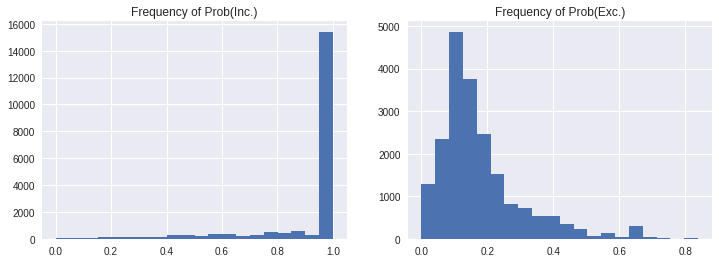

In [34]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
fig = plt.hist(df['Prob(Inc.)'],bins=20)
title = plt.title('Frequency of Prob(Inc.)')

plt.subplot(1,2,2)
fig = plt.hist(df['Prob(Exc.)'],bins=20)
title = plt.title('Frequency of Prob(Exc.)')

Based on this, we can see that Colony has a large number of "family/rows" with a very high inclusive probability.

### Percentage of Colony constructed families that are true Full Siblings, grouped by family size

I determine the percentage of Colony constructed families that include only full siblings.  The summary is broken out by family size and data set (`Nb_index`).   I excluded families with a single member, as the sibling analysis is irrelevant to only children.

It will be important to also filter this by probability thresholds!

In [35]:
# For each data set (folder), show the percentage of constructed families 
# consisting of only full siblings, grouped by family size.
group = ['Nb_index','family_size']
renamer = {'allFullSiblings': '% Full Siblings'}

# Only include families with more than 1 member, as "full siblings"
# is an irrelevant feature of single member families.
index = df['family_size'] > 1

# For our grouped data, aggregate:
#   full_sibs = the number of families where allFullSiblings == True
#   fam_count = the number of families
# Note, this works because Python True == 1, so sum() counts only True values
full_sibs = df[index].groupby(group).sum()[['allFullSiblings']]
fam_count = df[index].groupby(group).count()[['allFullSiblings']]

# Now, construct an easy-to-read table, sorted, and display it.
df2 = full_sibs / fam_count
df2 = df2.rename(columns=renamer)
df2['Full Sibling Families'] = full_sibs
df2['Total Families'] = fam_count
df2.sort_index()

% Full Siblings  Full Sibling Families  Total Families
Nb_index family_size                                                        
Nb10sim  2                   0.921387                  797.0             865
         3                   0.569231                  185.0             325
         4                   0.727749                  139.0             191
         5                   1.000000                    8.0               8
Nb29sim  2                   0.850168                  505.0             594
         3                   0.813121                  409.0             503
         4                   0.985915                   70.0              71
         5                   1.000000                   27.0              27
Nb30sim  2                   1.000000                 1031.0            1031
         3                   1.000000                  158.0             158
         4                   1.000000                    2.0               2
Nb31sim  2                   1.000000                 1038.0            1038
         3                   1.000000                  153.0             153
         4                   1.000000                    4.0               4
Nb50sim  2                   0.061654                   41.0             665
         3                   0.000000                    0.0              37

### Determine if same full-sibling families are replicated over multiple runs of Colony on the same source data set

From the project sponsor:

>Our goal with this new application is to see if the same full-sibling families are replicated over multiple runs of the Colony. Therefore, we would need to identify the parent#1xparent#2-ID# values that [are assigned to the same family] and see if those individuals are found in the same [family] in the other 99 replicate outputs.


To summarize: We pivot on our dataset to count the number of times the same exact family occurs, across multiple runs of Colony.

*Note: A family of full-siblings "AB" is counted only when the exact set "AB" occurs.  If "ABC" occurs, that is not added to the Count for family "AB".*


In [36]:
# Count the number of reoccurrence of identical families in multiple runs of the same data set.
df2 = df[(df['allFullSiblings']) & (df['family_size'] > 1)].groupby(['Nb_index','Members']).size().reset_index(name='Occurrence')

# Sort by data set and then by Count, then clean up the index.
df3 = df2.sort_values(by=['Nb_index','Occurrence'],ascending=[True,False]).reset_index().drop(columns='index')

# Add a column that shows the number of Colony runs per data set, and then calculate percentage.
# Calculate the number of files that were loaded per folder
nb_index_file_count = df.groupby(['Nb_index']).source.nunique()

df3['Total Runs'] = df3['Nb_index'].apply(lambda x: nb_index_file_count[x])
df3['% Exact Family Occurs'] = df3['Occurrence'] / df3['Total Runs']

# Display the first 10 results
df3.head(10)

,Nb_index,Members,Occurrence,Total Runs,% Exact Family Occurs
0,Nb10sim,"(63x20-15, 63x20-9)",100,100,1.00
1,Nb10sim,"(20x33-1, 20x33-6)",95,100,0.95
2,Nb10sim,"(63x20-12, 63x20-16)",95,100,0.95
3,Nb10sim,"(20x33-5, 20x33-8)",79,100,0.79
4,Nb10sim,"(33x4-43, 33x4-47, 33x4-48)",79,100,0.79
5,Nb10sim,"(63x47-49, 63x47-53, 63x47-54, 63x47-55)",79,100,0.79
6,Nb10sim,"(20x66-26, 20x66-28)",58,100,0.58
7,Nb10sim,"(20x66-27, 20x66-29, 20x66-32)",58,100,0.58
8,Nb10sim,"(33x4-44, 33x4-45)",58,100,0.58
9,Nb10sim,"(14x66-33, 14x66-39)",42,100,0.42


Here we can see that for the collection of Colony runs in the `Nb10sim` group:

* There were 100 total runs in this group (100 text files)
* In the first 10 rows (displayed), some families occur 100% of the time, some less than 50% of the time
* For example, in the second row, the exact family `23x33-1, 23x33-6` is found in 95 out of 100 Colony files for this group.

**The most recently generated complete set is available at [colony-percent-exact-family-occurs.csv](https://drive.google.com/open?id=18bSa9GkiNuCQRgIsWZ7GY0XCgsSlzjN7)**



In [0]:
# Save the results in a file
df3.to_csv('colony-percent-exact-family-occurs.csv')
from google.colab import files
files.download('colony-percent-exact-family-occurs.csv')

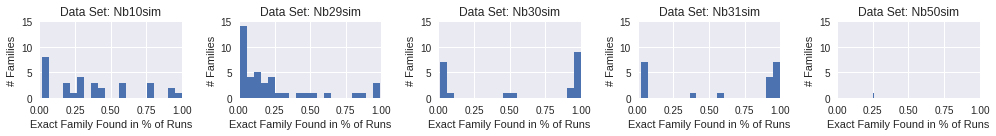

In [38]:
plt.figure(figsize=(14,2))

sets = df3.Nb_index.unique()
for i, nbindex in enumerate(sets):
    plt.subplot(len(sets)/5, 5, i+1)
    fig = plt.hist( df3[df3['Nb_index'] == nbindex]['% Exact Family Occurs'], bins=20)
    plt.xlabel('Exact Family Found in % of Runs')
    plt.ylabel('# Families')
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,15.0)
    plt.title('Data Set: %s' % nbindex)
    
plt.tight_layout()

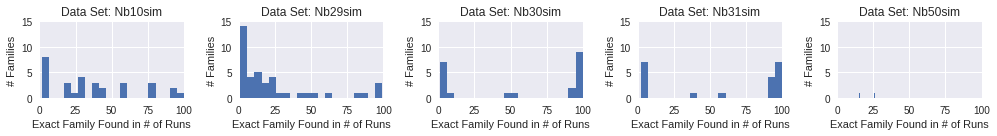

In [39]:
plt.figure(figsize=(14,2))

sets = df3.Nb_index.unique()
for i, nbindex in enumerate(sets):
    plt.subplot(len(sets)/5, 5, i+1)
    fig = plt.hist( df3[df3['Nb_index'] == nbindex]['Occurrence'], bins=20)
    plt.xlabel('Exact Family Found in # of Runs')
    plt.ylabel('# Families')
    plt.xlim(0.0,100)
    plt.ylim(0.0,15.0)
    plt.title('Data Set: %s' % nbindex)
    
plt.tight_layout()

The next step here is to plot these histograms with filtered data, for various values of probability thresholds.

Specifically, exclude all rows in the dataset below a particular threshold, plot the series of graphs for that data, and loop until all thresholds have been visualized.

#### And, again with Thresholds

Filter by inclusive probability, then exclusive probability.

With Inclusive Probability > 0.95


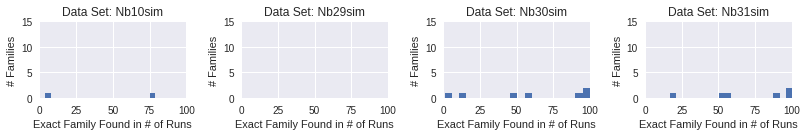

With Inclusive Probability > 0.9


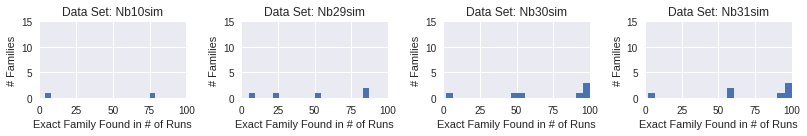

With Inclusive Probability > 0.8


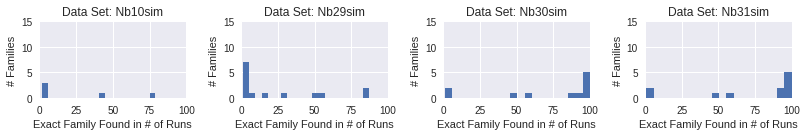

With Inclusive Probability > 0.7


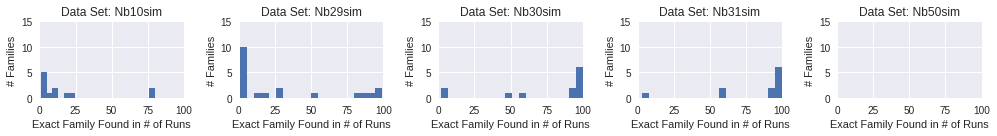

With Inclusive Probability > 0.5


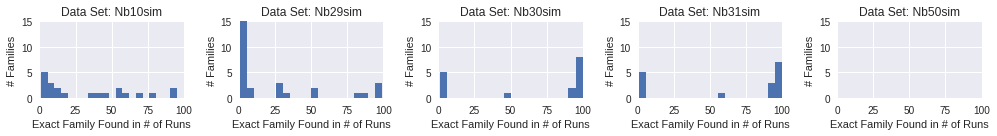

In [53]:
for threshold in [0.95, 0.9, 0.8, 0.7, 0.5]:
  # Count the number of reoccurrence of identical families in multiple runs of the same data set.
  df2 = df[(df['allFullSiblings']) & (df['family_size'] > 1) & (df['Prob(Inc.)'] > threshold)].groupby(['Nb_index','Members']).size().reset_index(name='Occurrence')

  # Sort by data set and then by Count, then clean up the index.
  df3 = df2.sort_values(by=['Nb_index','Occurrence'],ascending=[True,False]).reset_index().drop(columns='index')

  # Add a column that shows the number of Colony runs per data set, and then calculate percentage.
  # Calculate the number of files that were loaded per folder
  nb_index_file_count = df.groupby(['Nb_index']).source.nunique()

  df3['Total Runs'] = df3['Nb_index'].apply(lambda x: nb_index_file_count[x])
  df3['% Exact Family Occurs'] = df3['Occurrence'] / df3['Total Runs']

  plt.figure(figsize=(14,2))

  print("With Inclusive Probability > %s" % threshold)
  sets = df3.Nb_index.unique()
  for i, nbindex in enumerate(sets):
      plt.subplot(len(sets)/4, 5, i+1)
      fig = plt.hist( df3[df3['Nb_index'] == nbindex]['Occurrence'], bins=20)
      plt.xlabel('Exact Family Found in # of Runs')
      plt.ylabel('# Families')
      plt.xlim(0.0,100)
      plt.ylim(0.0,15.0)
      plt.title('Data Set: %s' % nbindex)

  plt.tight_layout()
  plt.show()

With Exclusive Probability > 0.5


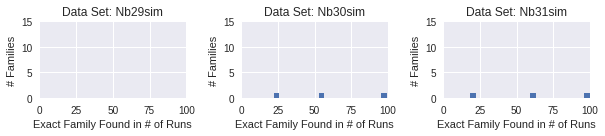

With Exclusive Probability > 0.4


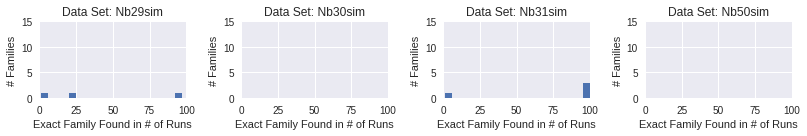

With Exclusive Probability > 0.3


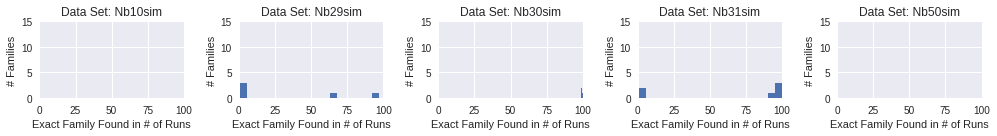

With Exclusive Probability > 0.2


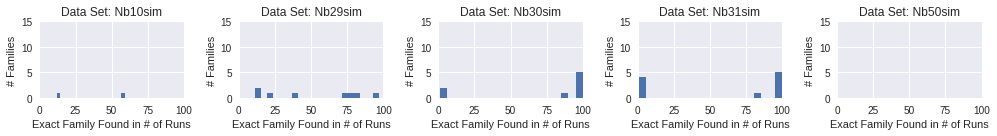

With Exclusive Probability > 0.1


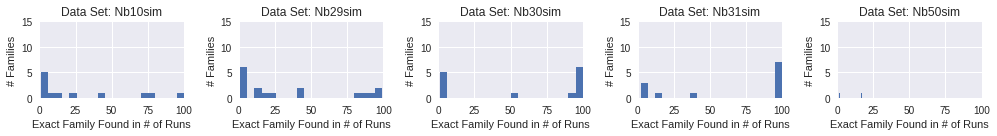

In [57]:
for threshold in [0.5, 0.4, 0.3, 0.2, 0.1]:
  # Count the number of reoccurrence of identical families in multiple runs of the same data set.
  df2 = df[(df['allFullSiblings']) & (df['family_size'] > 1) & (df['Prob(Exc.)'] > threshold)].groupby(['Nb_index','Members']).size().reset_index(name='Occurrence')

  # Sort by data set and then by Count, then clean up the index.
  df3 = df2.sort_values(by=['Nb_index','Occurrence'],ascending=[True,False]).reset_index().drop(columns='index')

  # Add a column that shows the number of Colony runs per data set, and then calculate percentage.
  # Calculate the number of files that were loaded per folder
  nb_index_file_count = df.groupby(['Nb_index']).source.nunique()

  df3['Total Runs'] = df3['Nb_index'].apply(lambda x: nb_index_file_count[x])
  df3['% Exact Family Occurs'] = df3['Occurrence'] / df3['Total Runs']

  plt.figure(figsize=(14,2))

  print("With Exclusive Probability > %s" % threshold)
  sets = df3.Nb_index.unique()
  for i, nbindex in enumerate(sets):
      plt.subplot(len(sets)/3, 5, i+1)
      fig = plt.hist( df3[df3['Nb_index'] == nbindex]['Occurrence'], bins=20)
      plt.xlabel('Exact Family Found in # of Runs')
      plt.ylabel('# Families')
      plt.xlim(0.0,100)
      plt.ylim(0.0,15.0)
      plt.title('Data Set: %s' % nbindex)

  plt.tight_layout()
  plt.show()

#### and with subset matching... (todo)
I think the **next steps** here are to write a function that counts based on subset matching.  So:

`f(thisFamily, otherFamily) if thisFamily is a subset of otherFamily return 1 else return 0`

Then, for each row, sum f() over all the otherFamilies in the `Nb_index` dataset and save that as a calculated column.